In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

A graph of 3 nodes:
0:[1]
1:[0]
2:[]

Nodes: [0, 1, 2]
Edges: [(0, 1)]


/Users/sacha/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


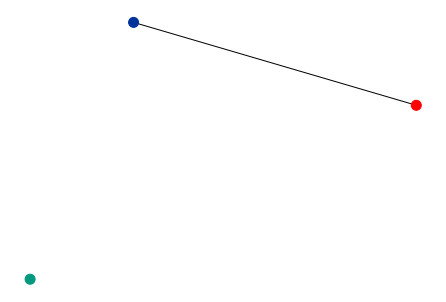

In [2]:
class Graph():
    def __init__(self):
        self.gdict = {}
        self.values = {}    # 0 for healthy, 1 for infected
        
    def add_node(self, node, val=None):
        """If node is not in a dictionary, add it."""
        if node not in self.gdict:
            self.gdict[node] = []
        self.values[node] = val
    
    def add_edge(self, node1, node2):        
        self.add_node(node1)
        self.add_node(node2)
        # Add node2 as a connection for node1, and the other way around
        if node2 not in self.gdict[node1]:
            self.gdict[node1].append(node2)
        if node1 not in self.gdict[node2]:
            self.gdict[node2].append(node1)
            
    def delete_edge(self, node1, node2):
        if node1 not in self.gdict[node2]: return # This edge doesn't exist, done
        self.gdict[node1].remove(node2)
        self.gdict[node2].remove(node1)
            
    def get_nodes(self):
        """Returns a list of nodes."""
        return list(self.gdict.keys())
    
    def get_edges(self):
        """Returns a list of edges."""
        out = []
        for node,links in self.gdict.items():
            for link in links:
                if node<link:
                    out.append((node,link))
        return out
            
    def __str__(self):
        out = 'A graph of ' + str(len(self.gdict)) + ' nodes:\n'
        for node in self.gdict:
            out += str(node) + ':' + str(self.gdict[node]) + '\n'
        return out
    
    def plot(self):
        RED = (1, 0, 0)
        BLUE = (0, 0.2, 0.6)
        GREEN = (0, 0.6, 0.5)
        
        g_nx = nx.Graph()
        nodes = self.get_nodes()
        g_nx.add_nodes_from(nodes)
        g_nx.add_edges_from(self.get_edges())
        colors = []
        for i in range(len(nodes)):
            if self.values[nodes[i]] is not None:
                if self.values[nodes[i]][0]=='healthy':
                    colors.append(BLUE)
                elif self.values[nodes[i]][0]=='infected':
                    colors.append(RED)
                else:
                    colors.append(GREEN)
            else:
                colors.append(BLUE)
        nx.draw_kamada_kawai(g_nx, node_size=100, node_color=colors)
        #nx.draw_spring(g_nx, node_size=100, node_color=colors)
    
# Test
g = Graph()
g.add_edge(0,1)
g.add_edge(0,2)
g.delete_edge(0,2)
print(g)
print('Nodes:',g.get_nodes())
print('Edges:',g.get_edges())
g.values[0] = ['infected', None]
g.values[2] = ['immune', None]
g.plot()

In [3]:
def degrees(g):
    """Calculates and plots the degrees distribution for a graph."""
    degrees = []
    for node,links in g.gdict.items():
        degrees.append(len(links))

    #print(degrees)
    hist = np.zeros(max(degrees)+1)
    for degree in degrees:
        hist[degree] += 1
    #print(hist)

    plt.plot(hist,'.-');
    plt.xlabel('Degrees')
    plt.ylabel('Frequency')
    
    return hist

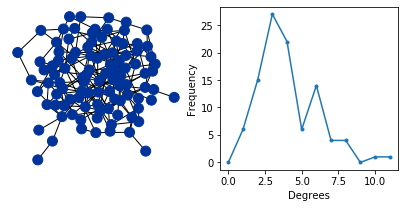

In [4]:
def random_network(n_nodes=7):
    """Creates a random (Erdos type II) network, with N(E)=N(V)."""
    n_edges = 2*n_nodes

    g = Graph()
    for i in range(n_nodes):
        g.add_node(i)
    edges = []
    while len(edges)<n_edges:
        n1 = np.random.randint(low=0, high=n_nodes)
        n2 = np.random.randint(low=0, high=n_nodes)
        if n2<n1:
            n1,n2 = n2,n1

        if (n1,n2) not in edges and n1!=n2:
            g.add_edge(n1,n2)
            edges.append((n1,n2))
    return g
    
#print(g)

g = random_network(100)
plt.figure(figsize=(7,3))
plt.subplot(121)
g.plot()
plt.subplot(122)
degrees_random = degrees(g)

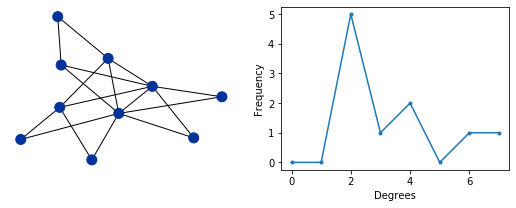

In [5]:
def barabasi(n_nodes=7):
    """Barabasi-Alberts network creator. N_edges ~ 2*N_nodes."""
    g = Graph()
    degrees = np.zeros(n_nodes)
    nodes = np.array(range(n_nodes))
    for i in range(n_nodes):
        if i==0:
            g.add_node(0)
        elif i==1:
            g.add_edge(1,0)
            degrees[0] = 1
            degrees[1] = 1
        else: # Actual preferential attachment
            connections = np.random.choice(nodes[:i], size=2, replace=False, p=degrees[:i]/np.sum(degrees))
            for node in connections:
                g.add_edge(i, node)
                degrees[node] += 1
            degrees[i] = 2
        #print(i,'Nodes:',nodes,'Degrees:',degrees)
    return g

g = barabasi(10)
plt.figure(figsize=(9,3))
plt.subplot(121)
g.plot()
plt.subplot(122)
degrees(g);

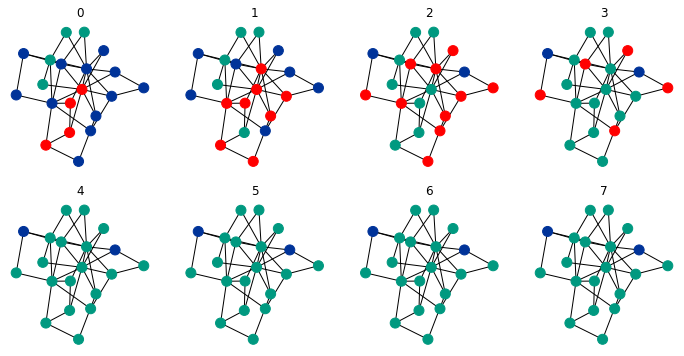

In [6]:
def pandemic(g, prob=0.5, nsteps=10, infect_period=1, vax_rate=0, reinitialize=True):
    """Runs the pandemic for several steps."""
    nodes = g.get_nodes()
    if reinitialize:
        for node in nodes:
            if np.random.uniform()<vax_rate:
                g.values[node] = ['immune', 0]       # Vaccinated
            else:
                g.values[node] = ['healthy', 0]      # Succeptible
        patient_zero = np.random.randint(low=0, high=len(nodes))
        g.values[patient_zero] = ['infected', 0]  # Only one node is sick

    history = np.zeros(nsteps)
    for t in range(nsteps):
        newly_infected = []
        is_active = False
        for node in nodes:
            if g.values[node][0] == 'infected':         # If the node is infectious
                is_active = True
                if g.values[node][1] == infect_period:
                    g.values[node][0] = 'immune'
                else:
                    g.values[node][1] += 1                  # One more day since the infection
                    neighbors = g.gdict[node]
                    for neighbor in neighbors:
                        if g.values[neighbor][0]=='healthy' and np.random.uniform()<prob:
                            newly_infected.append(neighbor)
        if not is_active:
            return history
        for node in newly_infected:
            g.values[node] = ['infected', 0]
        history[t] = len(newly_infected)
    return history

# Test case
g = barabasi(20)
plt.figure(figsize=(12,6))
for i in range(8):
    if i==0:
        pandemic(g, prob=0.5, nsteps=1, infect_period=1, vax_rate=0.1)
    else:
        pandemic(g, prob=0.5, nsteps=1, infect_period=1, reinitialize=False)
    plt.subplot(2,4,i+1)
    g.plot()
    plt.title(i)

In [7]:
# Computational experiment
N_STEPS = 20
N_NODES = 100
# PROB = 0.2      # Propagation probability: no longer a constant!
N_PROB_STEPS = 10  # Prob will take this many values, in equal steps, from 1/n to 1 (inclusive).
INFECT_PERIOD = 10
N_TRIALS = 100      # For each combination of parameters

history = np.zeros(shape=(N_STEPS, N_TRIALS*N_PROB_STEPS))
total_infected = np.zeros(shape=(N_TRIALS, N_PROB_STEPS))
prob = np.zeros(N_PROB_STEPS)
for iprob in range(N_PROB_STEPS):
    prob[iprob] = (iprob+1)/N_PROB_STEPS
    for itrial in range(N_TRIALS):
        g = barabasi(N_NODES)
        history[:, itrial+iprob*N_TRIALS] = pandemic(g, prob=prob[iprob], 
                                                     nsteps=N_STEPS, infect_period=INFECT_PERIOD)
        count_infected = 0
        for node, val in g.values.items():
            if val[0]=='immune':
                count_infected += 1
        total_infected[itrial, iprob] = count_infected

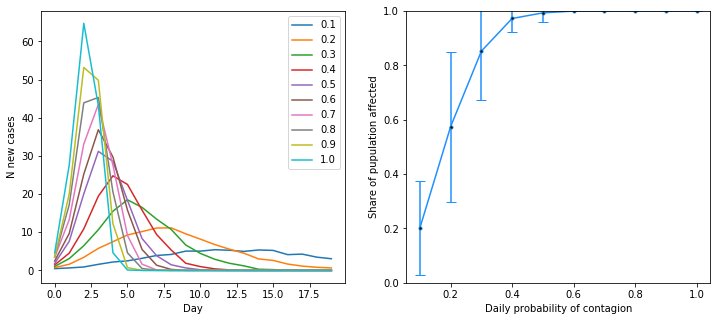

In [8]:
plt.figure(figsize=(12,5))
plt.subplot(121)
for iprob in range(N_PROB_STEPS):
    plt.plot(np.mean(history[:, (N_TRIALS*iprob):(N_TRIALS*(iprob+1))],axis=1), label=prob[iprob]);
plt.xlabel('Day');
plt.ylabel('N new cases');
plt.legend(loc='upper right');

plt.subplot(122)
plt.plot(prob, np.average(total_infected, axis=0)/N_NODES, '-', color='dodgerblue');
plt.errorbar(prob, np.average(total_infected, axis=0)/N_NODES, 
             yerr=np.std(total_infected, axis=0)/N_NODES, fmt='.', capsize=5,
             ecolor='dodgerblue', markerfacecolor='k');
plt.xlabel('Daily probability of contagion');
plt.ylabel('Share of pupulation affected');
plt.ylim(0,1);